# 1. Import Dependencies and Data

In [ ]:
!pip3 install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [62]:
!pip3 list

Package                  Version
------------------------ ---------
absl-py                  1.4.0
albumentations           1.3.1
appnope                  0.1.3
array-record             0.4.1
asttokens                2.2.1
astunparse               1.6.3
backcall                 0.2.0
blinker                  1.6.2
cachetools               5.3.1
certifi                  2023.7.22
charset-normalizer       3.2.0
click                    8.1.6
comm                     0.1.4
contourpy                1.1.0
cycler                   0.11.0
debugpy                  1.6.7
decorator                5.1.1
dm-tree                  0.1.8
etils                    1.4.1
executing                1.2.0
Flask                    2.3.2
flatbuffers              23.5.26
fonttools                4.42.0
gast                     0.4.0
google-api-core          2.11.1
google-api-python-client 2.95.0
google-auth              2.22.0
google-auth-httplib2     0.1.0
google-auth-oauthlib     1.0.0
google-pasta          

In [63]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [64]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt 

In [65]:
ds = tfds.load('fashion_mnist', split = 'train')
ds.as_numpy_iterator().next().keys()

2023-08-21 15:11:18.871717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['image', 'label'])

In [66]:
ds.as_numpy_iterator().next()['label']

2023-08-21 15:11:18.893217: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2

# 2. Visualise the data

In [67]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

2023-08-21 15:11:18.913560: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [68]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

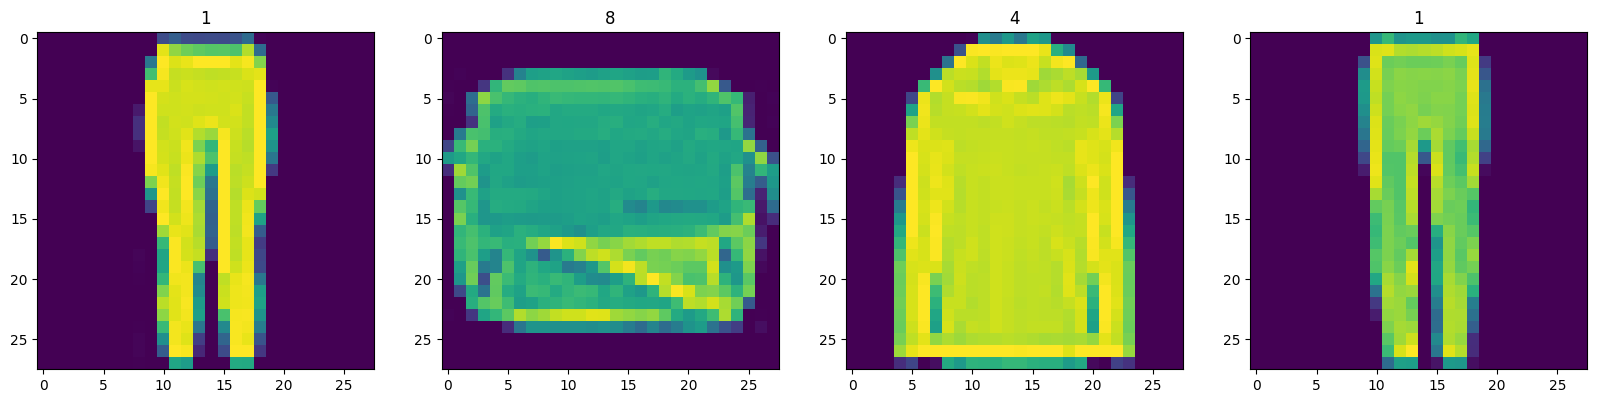

In [69]:
fig, ax = plt.subplots(ncols = 4, figsize= (20, 20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [70]:
# function to scale the images
def scale_images(data):
    image = data['image']
    return image/ 255

In [71]:
ds = tfds.load('fashion_mnist', split = 'train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)

# to reduce the chance of bottlenecking
ds = ds.prefetch(64)


In [72]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3.Building the Neural Network

Importing the architectural components

In [73]:
# sequential api for generator and discriminator
from tensorflow.keras.models import Sequential

# importing the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Building the generator

In [74]:
def build_generator():
    model = Sequential()

    # beginnings of generated image
    model.add(Dense(7 * 7 * 128, input_dim = 128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    #Upsampling Block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #Upsampling Block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #DownSampling block
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))

    #Down Sampling block
    model.add(Conv2D(128, 4, padding = 'same'))
    model.add(LeakyReLU(0.2))


    model.add(Conv2D(1, 4, padding = 'same', activation = 'sigmoid'))
    return model

In [75]:
test_model = build_generator()
test_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_9 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [76]:
generator = build_generator()
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 0s 58ms/step


array([[[[0.49785084],
         [0.4951566 ],
         [0.49453217],
         ...,
         [0.50611925],
         [0.5080981 ],
         [0.5053338 ]],

        [[0.4998426 ],
         [0.50590825],
         [0.50703216],
         ...,
         [0.5094721 ],
         [0.5066576 ],
         [0.505708  ]],

        [[0.4888508 ],
         [0.49977702],
         [0.5010576 ],
         ...,
         [0.5056068 ],
         [0.5035198 ],
         [0.50535995]],

        ...,

        [[0.4860322 ],
         [0.49216136],
         [0.4878234 ],
         ...,
         [0.4986053 ],
         [0.4989337 ],
         [0.50099075]],

        [[0.48544046],
         [0.4898959 ],
         [0.4877584 ],
         ...,
         [0.4968565 ],
         [0.49879214],
         [0.501428  ]],

        [[0.49056464],
         [0.49300507],
         [0.4974419 ],
         ...,
         [0.49941954],
         [0.50149584],
         [0.5021285 ]]],


       [[[0.49987626],
         [0.5041353 ],
         [0.49

In [77]:
generator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 6272)              809088    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_11 (UpSampli  (None, 14, 14, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                     

In [78]:
img.shape

(4, 28, 28, 1)

1/1 [==============================] - 0s 32ms/step


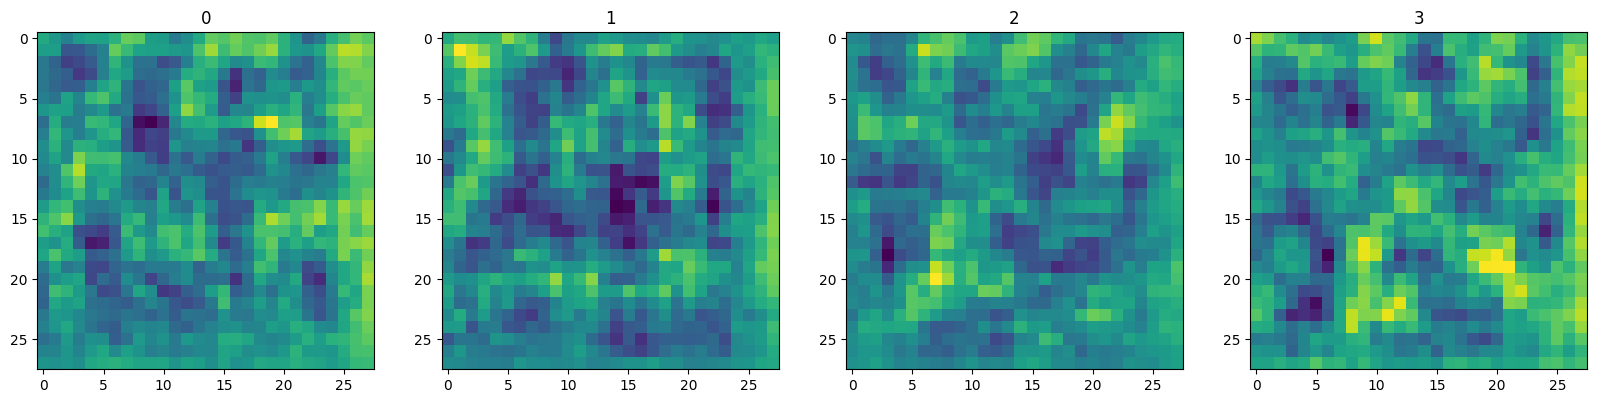

In [79]:
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))

    ax[idx].title.set_text(idx)

Building a Discriminator

In [80]:
def build_discriminator():
    model = Sequential()

    # first conv block 
    model.add(Conv2D(32, 5, input_shape = (28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Flatten
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation ='sigmoid'))

    return model

In [81]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_8 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 128)     

1/1 [==============================] - 0s 30ms/step


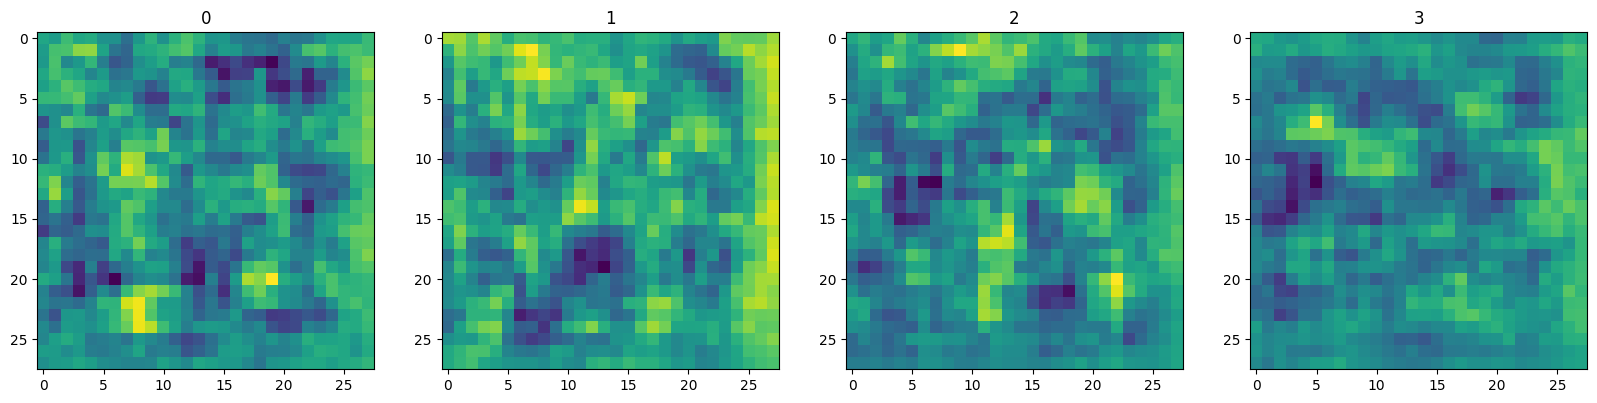

In [82]:
img = generator.predict(np.random.randn(4, 128, 1))
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

# 4. Custom training Loop

4.1 Setup Losses and Optimizers

In [83]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [84]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

4.2 Build Subclass model

In [103]:
from tensorflow.keras.models import Model


In [132]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # creating attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)

        #train the discriminator
        with tf.GradientTape() as d_tape:

            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)

            #create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis = 0)
            # zeros_like returns tensor of zeros of the shape of argument passed

            #Add some noise to the outputs 
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake +=tf.concat([noise_real, noise_fake], axis = 0)

            #Calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        #Apply backpropogation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables)) 

        # train the generator

        with tf.GradientTape() as g_tape:
            #generating some new images
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training = True)

            #Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training = False)

            #Calculate the loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        #backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [133]:
# creating an instance of the subclass
fashgan =FashionGAN(generator, discriminator)

In [134]:
#Compiling the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

4.3 Build Callback

In [135]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [136]:
class ModelMonitor(Callback):
    def __init__(self, num_img = 3, latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.generator(random_latent_vectors)
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

4.3 Train

In [ ]:
hist = fashgan.fit(ds, epochs=20, callbacks= [ModelMonitor()] )

# 5 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [143]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 151ms/step


In [ ]:
fig, ax = plt.subplots(ncols = 4, nrows = 4, figsize = (20, 20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

# Save the model

In [ ]:
generator.save('saved_model.h5')
discriminator.save('saved_discriminator.h5')